### Multicollinearity

In case of multicollinear (or highly correlated) features presence the vanilla linear models tends to suffer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def visualise(mu, sigma, points, x_ticklabels=None, title=None, greater_than_zero=False):
    if greater_than_zero:
        mu = np.clip(mu, 0, mu.max())
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    plt.plot(points, mu, "r", label="mean value")
    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate((
        [mu[i] - sigma[i] for i in range(len(points))], 
        [mu[i] + sigma[i] for i in range(len(points)-1, -1, -1)],
    ))
    if greater_than_zero:
        _y = np.clip(_y, 0, _y.max())
    plt.fill(_x, _y, fc='r', alpha=.2, ec=None, label='+- sigma range')
    
    if x_ticklabels is not None:
        ax.set_xticks(np.arange(len(x_ticklabels)))
        ax.set_xticklabels(x_ticklabels)
    
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid()

Let's generate new dataset with correlated features:

In [3]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43
eps = 1e-3

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

In [4]:
w_true

array([0.2511136 , 0.48042174, 0.57500532])

In [5]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([  0.2383509 ,  50.15493617, -49.10124141])

As we can see, the second and third coefficents are opposite. This makes our model highly *unstable*.

Same case with the gradient descent method:

In [6]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-3

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

w_list[-1]

array([ 0.62994334,  1.34279767, -0.29827923])

And stochastic gradient:

In [7]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 0.2

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)
w_list[-1]

array([ 0.21218985,  1.39792157, -0.24312954])

However, regularization can fix it:

In [8]:
w_star = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(n_features)).dot(X.T).dot(Y)
w_star

array([0.23840653, 0.57368584, 0.47999534])

The solution is *unstable*. Let's take a look at the *condition number* of our matrix:
$$\kappa(a) = \frac{\sigma_{\max(A)}}{\sigma_{\min(A)}}$$
where $\sigma_{\max(A)}$ and $\sigma_{\min(A)}$ are maximal and minimal singular values of $A$ respectively. Hence

In [9]:
def get_w_by_grad(X, Y, num_steps, w_0, step_size):
    w = w_0.copy()

    for i in range(num_steps):
        w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    return w

def get_w_by_stoch_grad(X, Y, num_steps, w_0, step_size_0, n_objects):
    w = w_0.copy()
    step_size_0 = 0.45

    for i in range(num_steps):
        step_size = step_size_0 / ((i+1)**0.51)
        sample = np.random.randint(n_objects, size=batch_size)
        w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    return w

def rmse(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred)

In [10]:
step_size = 1e-3
sgd_step_size = 0.1
num_steps = 250
noise_eps_seq = np.linspace(1e-2, 7e-7, 20)

In [11]:
condition_numbers = []
vector_norms_list = []
rmse_list = []
results_list = []
for eps in noise_eps_seq:
    local_condition_numbers = []
    local_vector_norms_list = []
    local_rmse_list = []
    for i in range(50):
        X[:, -1] = 2 * (X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape))

        a = np.linalg.eigvals(X.T.dot(X))
        local_condition_numbers.append(a.max() / a.min())

        w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        w_star_grad = get_w_by_grad(X, Y, num_steps, w_0, step_size)
        w_star_sgd = get_w_by_stoch_grad(X, Y, num_steps, w_0, sgd_step_size, n_objects)
        local_vector_norms_list.append([
            np.linalg.norm(w_star),
            np.linalg.norm(w_star_grad), 
            np.linalg.norm(w_star_sgd),
        ])

        analytical_predict = X.dot(w_star)
        grad_predict = X.dot(w_star_grad)
        sgd_predict = X.dot(w_star_sgd)
        
        local_rmse_list.append([
            rmse(Y, analytical_predict),
            rmse(Y, grad_predict),
            rmse(Y, sgd_predict),  # rmse
        ])
        
        results_list.append([w_star, w_star_grad, w_star_sgd])

    condition_numbers.append([np.mean(local_condition_numbers), np.std(local_condition_numbers)])
    vector_norms_list.append([
        np.mean(np.array(local_vector_norms_list), axis=0),
        np.std(np.array(local_vector_norms_list), axis=0),
    ])
    rmse_list.append(np.mean(np.array(local_rmse_list), axis=0))

condition_numbers = np.array(condition_numbers)
vector_norms_list = np.array(vector_norms_list)
rmse_list = np.array(rmse_list)

Take a close look to the collected vectors:

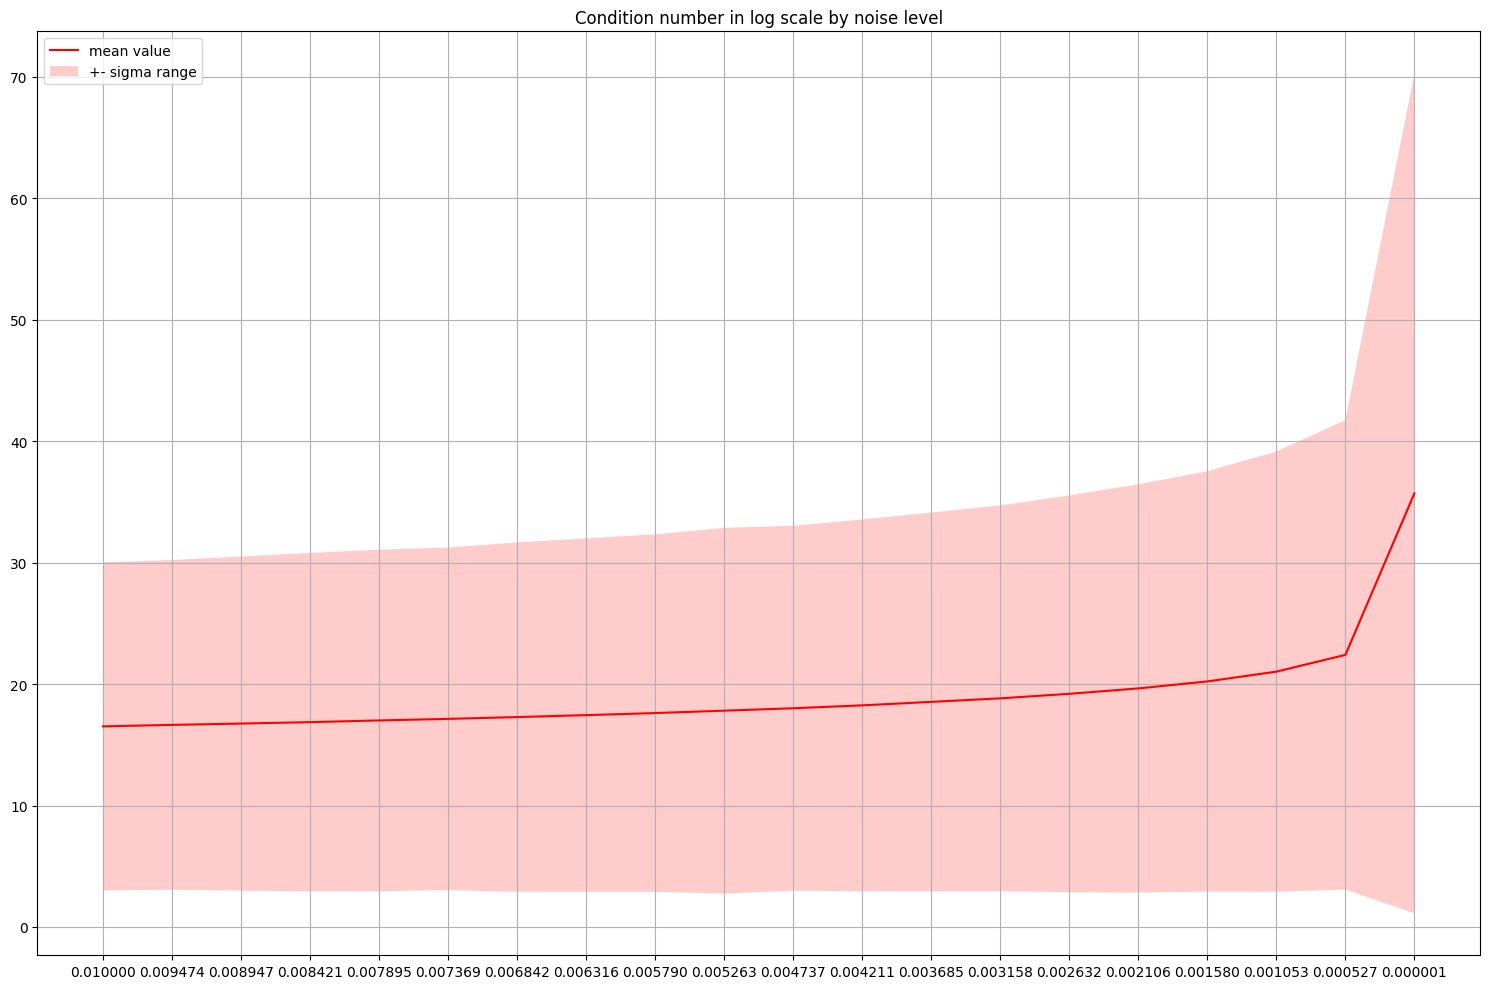

In [12]:
visualise(
    np.log(condition_numbers[:, 0]), 
    np.log(condition_numbers[:, 1]),
    np.arange(len(noise_eps_seq)), 
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Condition number in log scale by noise level',
    greater_than_zero=True,
)

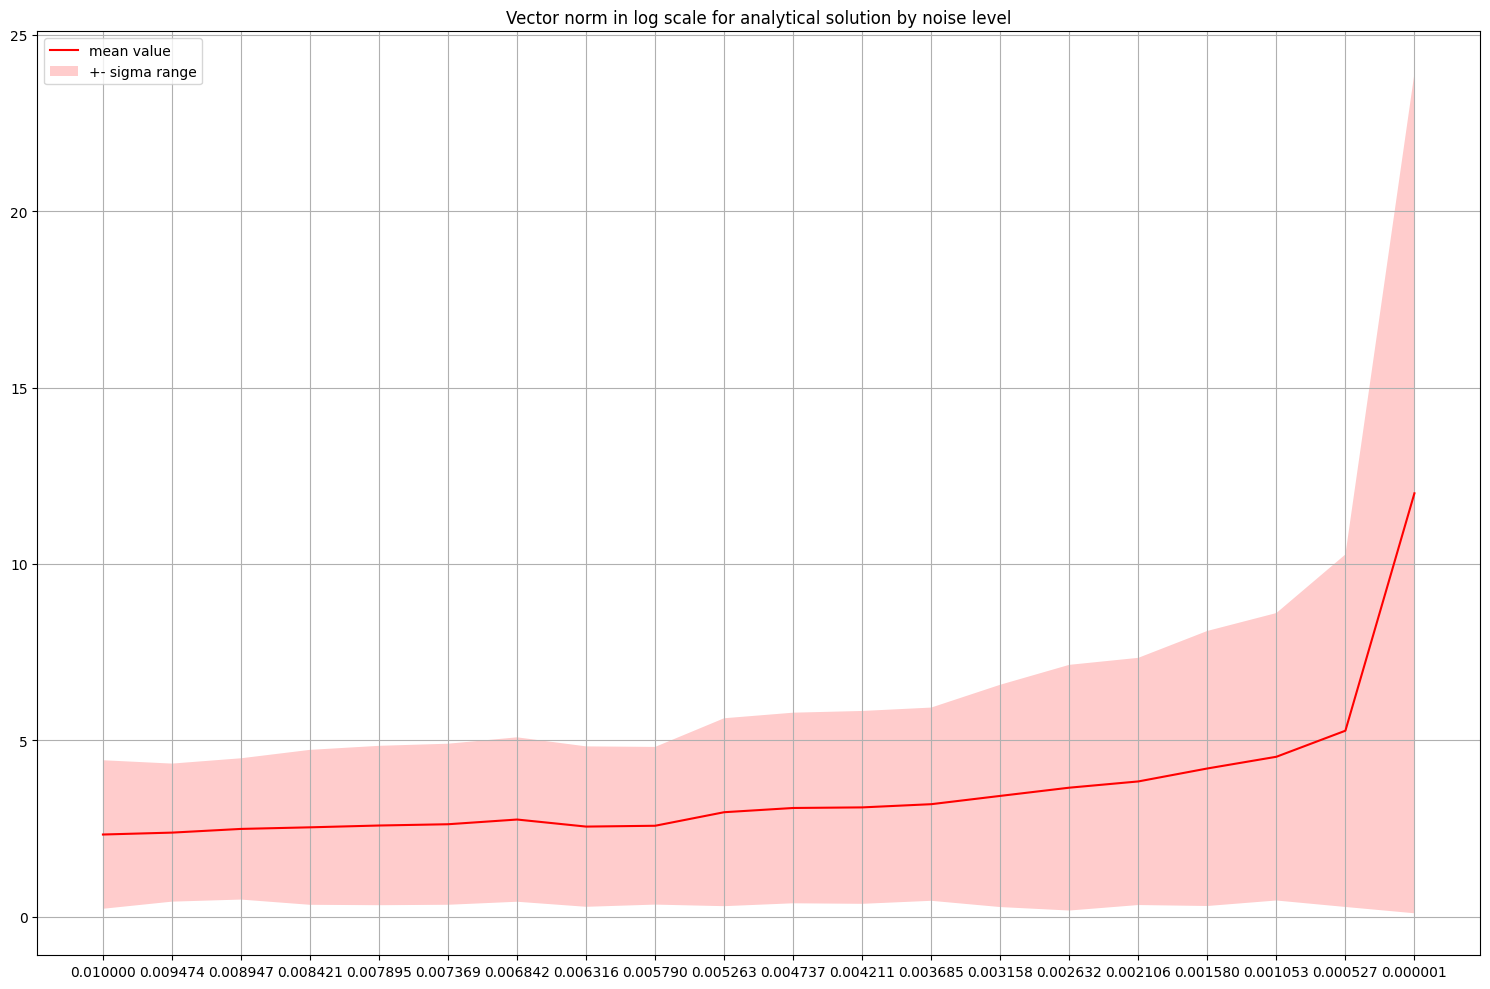

In [13]:
visualise(
    np.log(vector_norms_list[:, 0, 0]), 
    np.log(vector_norms_list[:, 1, 0]),
    np.arange(len(noise_eps_seq)), 
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in log scale for analytical solution by noise level',
    greater_than_zero=True,
)

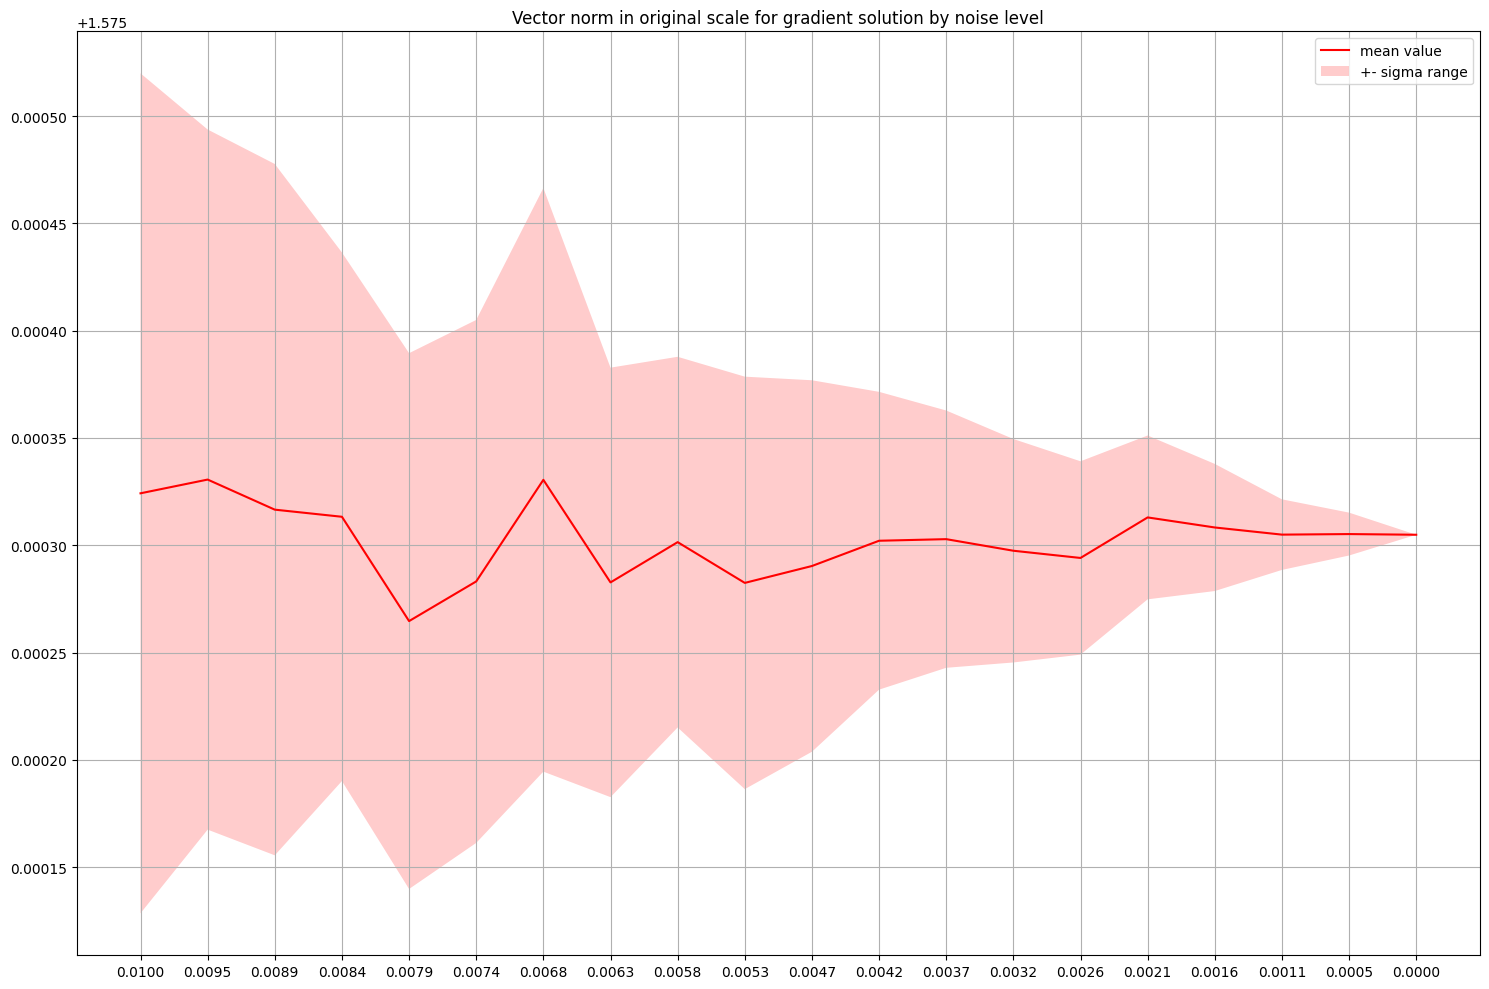

In [14]:
visualise(
    vector_norms_list[:, 0, 1], 
    vector_norms_list[:, 1, 1],
    np.arange(len(noise_eps_seq)), 
    ['{0:.4f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in original scale for gradient solution by noise level',
    greater_than_zero=True,
)

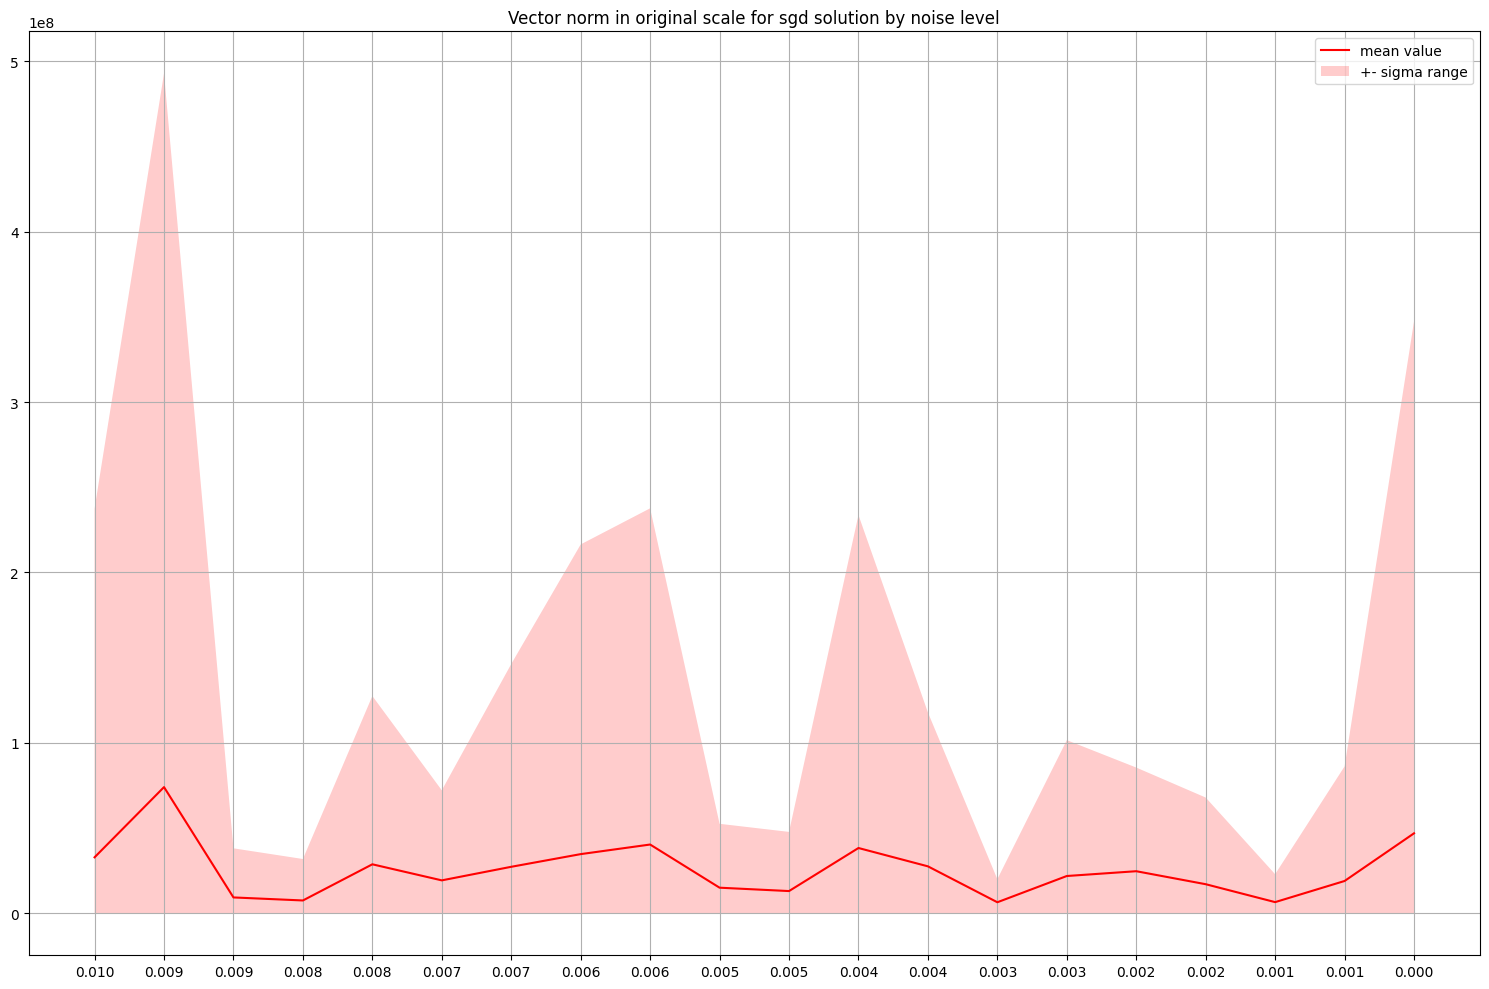

In [15]:
visualise(
    vector_norms_list[:, 0, 2], 
    vector_norms_list[:, 1, 2],
    np.arange(len(noise_eps_seq)), 
    ['{0:.3f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in original scale for sgd solution by noise level',
    greater_than_zero=True,
)

##  Вероятностный взгляд на линейную регрессию
Вероятностный подход дает красивую статистическую интерпретацию различных функций потерь и регуляризации.

### Вероятностный взгляд на функции потерь

В вероятностном подходе к машинному обучению все сущности (объекты, целевые переменные, параметры моделей) рассматриваются как случайные величины. Задача ставится следующим образом: надо найти распределение на эти случайные величины, которое лучше всего описывает данные (множество пар объект $-$ целевой признак). Это распределение будет описывать процесс порождения наших данных (рассмотрим далее на прмиерах). На этом семинаре мы будем рассматривать дискриминативные модели, в которых предсказывается распределение на целевую переменную при заданном объекте: $p(y_i|x_i, \theta)$, $\theta$ — параметры модели. Другой подход — это моделировать совместное распределение $p(y_i, x_i|\theta)$ (генеративная модель).

Для настройки параметров в вероятностном подходе часто применяют метод максимального правдоподобия, известный вам из курса математической статистики. В нем правдоподобие вероятностной модели:
$$p(y|X, \theta) = \prod_i p(y_i|x_i, \theta)$$
логарифмируется и оптимизируется по параметрам модели:
$$\log p(y|X, \theta) = \sum_i \log p(y_i|x_i, \theta) \rightarrow \max_{\theta}.$$

До этого момента мы рассматривали только точечные предсказания: $y_i = w^T x_i$. Когда мы начинаем рассматривать $y_i$ как случайную величину, мы как бы признаем неточность этого предсказания и допускаем, что можем ошибиться. Логично взять распределение $p(y_i|x_i, \theta)$, имеющее моду в $y = w^T x$ и монотонно убывающее слева и справа от нее. Для начала возьмем нормальное распределение:
$$p(y_i|x_i, \theta) = \mathcal{N}(y_i|x_i^T w, \sigma^2).$$
Здесь мы обозначили $\theta=\{w, \sigma\}$ — множество параметров вероятностной модели. Процесс порождения данных в этом случае предельно простой: мы предполагаем, что $y_i$ случайно сгенерировано из $\mathcal{N}(y_i|x_i^T w, \sigma^2)$.

__Задача.__ Найдите, какой функции потерь соответствует метод максимального правдоподобия для данной модели.

_Решение._ Преобразуем логарифм правдоподобия:
$$\log p(y|X, \theta) = \sum_i \log \mathcal{N}(y_i|x_i^T w, \sigma^2) = $$
$$=\sum_i \log \biggl( \frac{1}{\sqrt{2\pi}\sigma}exp\bigl(-\frac {(y_i - w^T x_i)^2} {2 \sigma^2}  \bigr)\biggr)=$$
$$=\sum_i \biggl( -0.5 \log(2\pi) - \log \sigma  -\frac {(y_i - w^T x_i)^2} {2 \sigma^2} \biggr) = $$
$$=C - \frac 1 {2 \sigma^2} \sum_i (y_i - w^T x_i)^2 \rightarrow \max_{w}, \quad C = -\frac \ell 2 \log(2\pi)  $$
Константы $C$, $\sigma$ не влияют на точку оптимума, а знак минус можно удалить, заменив задачу макисимзации на задачу минимизации, поэтому в итоге мы получаем слудеющую оптимизационную задачу:
$$ \sum_i (y_i - w^T x_i)^2 \rightarrow \min_w $$
Мы видим, что применение метода максимального правдоподобия к нашей задаче равносильно оптимизации MSE, что соответствует квадратичной функции потерь. 

Итак, вероятностный подход дает следующую интерпретацию квадратичной функции потерь для линейных моделей: при ее применении мы предполагаем, что 
1. зависимость целевой переменной от признаков линейна
2. ошибки предсказаний линейной модели распределены нормально.   

На практике последнее условие можно попробовать проверить графически, а именно: построить гистограмму ошибок и оценить ее нормальность. Конечно, в статистике существуют специальные тесты для проверки нормальности, но мы не будем их затрагивать. 

Пример гистограммы ошибок на наших данных:

In [16]:
from sklearn.linear_model import LinearRegression

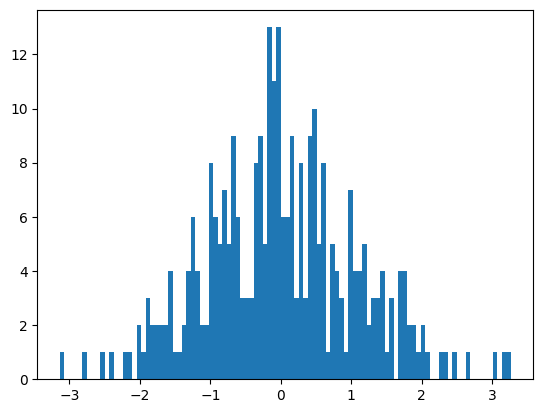

In [17]:
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)
plt.hist(Y_pred - Y, 100)
plt.show()

Аналогично можно провести анализ, если вместо нормального распределения взять, к примеру, распределение Лапласа:
$$p(y_i|x_i, \theta=\{w, \alpha\}) = \frac \alpha 2 \exp \bigl( -\alpha \bigl|y_i - w^Tx_i\bigr| \bigr).$$
Для этой модели метод максимального правдоподобия соответствует оптимизации MAE.

### Вероятностный взгляд на регуляризацию
Во всех предыдущих рассуждениях мы рассматривали только целевую переменную как случайную величину, а признаки объекта и веса считали фиксированным векторамию. Мы можем несколько усложнить нашу вероятностную модель и считать, что веса модели — тоже случайная величина. Здесь мы придем к понятию априорного распределения $p(w)$: это распределение на веса линейной модели, отображающее наше представление о них до того, как к нам поступили данные. Модель порождения данных тогда будет выглядеть так:
1. Сгенерировать вектор весов $w \sim p(w)$;
1. Для всех объектов сгенерировать $y_i \sim p(y_i|x_i, \theta=\{w, \dots\})$.
Вероятностная модель:
$$p(y, w|X) = \bigl [ \prod_i p(y_i|x_i, \theta) \bigr ] p(w). $$

Когда мы получили данные, мы можем искать наиболее вероятное значение весов — моду апостериорного распределения $p(w|X, y)$.

__Задача.__ Какому критерию качества соответствует поиск моды апостериорного распределения, если $p(w)=\mathcal{N}(w|0, I)$ — стандартное многомерное нормальное распределение?

_Решение._
Найдем моду распределения. По формуле Байеса:
$$p(w|X,y) = \frac {p(y|X, w)p(w)}{p(y|X)} = \frac {\prod_i p(y_i|x_i, w) p(w)}{p(y|X)} $$
Знаменатель не зависит от $w$ и не повлияет на точку моды распределения, поэтому не будем далее его рассматривать. Прологарифмируем числитель:
$$\sum_i \log p(y_i|x_i, w) + \log p(w) \rightarrow \max_{w}$$
Первое слагаемое мы уже вычисляли ранее, оно соответствует среднеквадратичному отклонению. Займемся вторым слагаемым:
$$\log p(w) = \log \mathcal{N}(w|0, I) = \log \biggl( \frac{1}{\sqrt{2\pi}^d }exp\bigl(-\frac {w^T w} {2 }  \bigr)\biggr) =$$
$$- \frac d 2 \log \pi  -\frac {w^T w} {2 } .$$
Первое слагаемое — константа, не влияющая на точку минимума, второе слагаемое — евклидова норма весов. Итак, мы получили следующий оптимизируемый критерий:
$$- \frac 1 {2 \sigma^2}\sum_i (y_i - w^T x_i)^2 + \frac 1 2 w^Tw \rightarrow \min_w$$
Это в точности соответствует $L_2$-регуляризованной линейной регрессии. Обратите внимание, что здесь мы уже не можем опустить множитель $\frac 1 {2 \sigma^2}$. Семантически он соответствует коэффициенту регуляризации и настраивает баланс между оптимизацией качества решения задачи и регуляризатором.

Аналогично можно рассмотреть, к примеру, априорное распределение Лапласа и получить, что оно соответствует $L_1$-регуляризации в линейной регрессии.

Напоследок (в этой секции) отметим, что все приведенные рассуждения можно повторить для любых алгоритмов машинного обучения, заменив $w^Tx$ на другую модель зависимости.
